## Alberto Lovell

In [43]:
import numpy as np
import pandas as pd
import scipy.stats as scs
import datetime as dt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

## Purpose: 

The goal of this exercise is to design a model to predict discount percentages for newly encountered line items

In [45]:
df = pd.read_csv('sales_data.csv')
df.head()

,user_id,user_id_type,cart_id,date_modified,currency,unit_price,net_price,discountpercent,recurring_unit_price,recurring_net_price,recurring_discountpercent,quantity,product_system_id,deal_type,opportunity_region,opportunity_budget,contract_term,total_contract_value,deal_category
0,525,8477949227256649820,525-1,02/22/2017 03:30:01.050000,GBP,0.0,0.0,0.0,0.000000,0.000000,0.0,78.0,1789161784535801413,Renewal,UK&I,"""Less than 1",0.0,12,-1575416002466453954
1,525,8477949227256649820,525-1,02/22/2017 03:30:01.050000,GBP,0.0,0.0,0.0,6.923077,6.923077,0.0,78.0,-3388033280723878524,Renewal,UK&I,"""Less than 1",0.0,12,-1575416002466453954
2,525,8477949227256649820,525-1,02/22/2017 03:30:01.050000,GBP,0.0,0.0,0.0,0.000000,0.000000,0.0,8.0,-9130972624394922538,Renewal,UK&I,"""Less than 1",0.0,12,-1575416002466453954
3,525,8477949227256649820,525-1,02/22/2017 03:30:01.050000,GBP,0.0,0.0,0.0,187.500000,187.500000,0.0,8.0,2739638421988212911,Renewal,UK&I,"""Less than 1",0.0,12,-1575416002466453954
4,525,8477949227256649820,525-1,02/22/2017 03:30:01.050000,GBP,0.0,0.0,0.0,0.000000,0.000000,0.0,8.0,-6185560453609870674,Renewal,UK&I,"""Less than 1",0.0,12,-1575416002466453954


In [195]:
df['discountpercent'].describe()

count    131650.000000
mean          0.323001
std          19.124630
min        -100.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          99.990000
Name: discountpercent, dtype: float64

Since our target unit is a percentage, I chose the standard deviation (19.12%) as the baseline performance metric. A well performing model will predict within the standard deviation

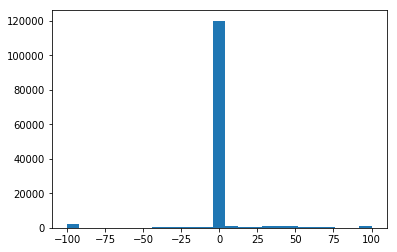

In [201]:
c = df['discountpercent'].values
plt.hist(c, bins=25);

Target data is highly imbalanced and shows a multi-class characteristic (-100, 0, 100), however since there are continuous values I decided to treat this as a regression and not classification

## Exploratory Data Analysis

In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131883 entries, 0 to 131882
Data columns (total 19 columns):
user_id                      131883 non-null int64
user_id_type                 131883 non-null int64
cart_id                      131883 non-null object
date_modified                131883 non-null object
currency                     131883 non-null object
unit_price                   131883 non-null float64
net_price                    131883 non-null float64
discountpercent              131883 non-null float64
recurring_unit_price         131883 non-null float64
recurring_net_price          131883 non-null float64
recurring_discountpercent    131883 non-null float64
quantity                     131883 non-null float64
product_system_id            131883 non-null int64
deal_type                    131883 non-null object
opportunity_region           131883 non-null object
opportunity_budget           131883 non-null object
contract_term                131883 non-null float64


In [140]:
df.describe()

,user_id,user_id_type,unit_price,net_price,discountpercent,recurring_unit_price,recurring_net_price,recurring_discountpercent,quantity,product_system_id,contract_term,deal_category
count,131883.000000,1.318830e+05,131883.000000,131883.000000,131883.000000,131883.000000,131883.000000,1.318830e+05,131883.000000,1.318830e+05,131883.000000,1.318830e+05
mean,1221.127204,-3.854135e+17,1.963710,1.326602,0.323806,58.786813,49.757162,-2.231985e+02,212.334433,-9.158149e+16,0.563313,-4.553766e+17
std,376.285154,6.064833e+18,8.641955,4.315969,19.111947,2353.348876,1941.070033,5.607483e+04,532.074494,4.800088e+18,3.484257,2.740637e+18
min,229.000000,-8.776407e+18,0.000000,0.000000,-100.000000,-1.000000,-1.000000,-1.977690e+07,0.350000,-9.172401e+18,0.000000,-8.390404e+18
25%,924.000000,-6.194651e+18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,-3.482694e+18,0.000000,-1.575416e+18
50%,1287.000000,8.021775e+16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,-5.642370e+17,0.000000,-1.575416e+18
75%,1436.000000,8.477949e+18,0.090000,0.050000,0.000000,0.000000,0.000000,0.000000e+00,100.000000,4.374357e+18,0.000000,2.540208e+18
max,2030.000000,8.844500e+18,213.766076,25.263157,99.990000,471867.760941,157289.253647,1.000000e+02,3032.000000,9.221542e+18,61.000000,8.412271e+18


In [46]:
df['user_id'].describe()

count    131883.000000
mean       1221.127204
std         376.285154
min         229.000000
25%         924.000000
50%        1287.000000
75%        1436.000000
max        2030.000000
Name: user_id, dtype: float64

In [143]:
df['cart_id'].describe()

count     131883
unique     23884
top       1389-6
freq         888
Name: cart_id, dtype: object

## Data Cleaning

Cleaning and structuring data involved converting dataframe object columns into a usable format. This included stripping characters, converting to numeric values, converting categorical variables into dummy variables, converting datetime into ordinal numbers, replacing nan values where appropriate (using the mean in this case), and using t-tests to determine if line items could be dropped without significantly affecting the analysis.

In [144]:
#cart_id to float

df['cart_id'] = df['cart_id'].str.replace('-','.')
df['cart_id'] = df['cart_id'].astype(float)

In [145]:
#to datetime then to ordinal for regression

date = pd.to_datetime(df['date_modified'])
df['date_modified'] = date
df['date_modified'] = df['date_modified'].map(dt.datetime.toordinal)

In [147]:
df['currency'].unique()

array(['GBP', 'USD', 'EUR', 'AUD', 'NZD', 'SGD', 'CAD'], dtype=object)

In [148]:
#dummies

currency_dum = pd.get_dummies(df['currency'])
df = pd.concat([df, currency_dum], axis=1)
df = df.drop('currency', axis=1)
df.head()

,user_id,user_id_type,cart_id,date_modified,unit_price,net_price,discountpercent,recurring_unit_price,recurring_net_price,recurring_discountpercent,...,contract_term,total_contract_value,deal_category,AUD,CAD,EUR,GBP,NZD,SGD,USD
0,525,8477949227256649820,525.1,736382,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,12,-1575416002466453954,0,0,0,1,0,0,0
1,525,8477949227256649820,525.1,736382,0.0,0.0,0.0,6.923077,6.923077,0.0,...,0.0,12,-1575416002466453954,0,0,0,1,0,0,0
2,525,8477949227256649820,525.1,736382,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,12,-1575416002466453954,0,0,0,1,0,0,0
3,525,8477949227256649820,525.1,736382,0.0,0.0,0.0,187.500000,187.500000,0.0,...,0.0,12,-1575416002466453954,0,0,0,1,0,0,0
4,525,8477949227256649820,525.1,736382,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,12,-1575416002466453954,0,0,0,1,0,0,0


In [149]:
df['deal_type'].unique()

array(['Renewal', 'New From New', 'New From Existing', 'Credited'],
      dtype=object)

In [150]:
#dummies

dealtype_dum = pd.get_dummies(df['deal_type'])
df = pd.concat([df, dealtype_dum], axis=1)
df = df.drop('deal_type', axis=1)
df.head()

,user_id,user_id_type,cart_id,date_modified,unit_price,net_price,discountpercent,recurring_unit_price,recurring_net_price,recurring_discountpercent,...,CAD,EUR,GBP,NZD,SGD,USD,Credited,New From Existing,New From New,Renewal
0,525,8477949227256649820,525.1,736382,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0,0,1,0,0,0,0,0,0,1
1,525,8477949227256649820,525.1,736382,0.0,0.0,0.0,6.923077,6.923077,0.0,...,0,0,1,0,0,0,0,0,0,1
2,525,8477949227256649820,525.1,736382,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0,0,1,0,0,0,0,0,0,1
3,525,8477949227256649820,525.1,736382,0.0,0.0,0.0,187.500000,187.500000,0.0,...,0,0,1,0,0,0,0,0,0,1
4,525,8477949227256649820,525.1,736382,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0,0,1,0,0,0,0,0,0,1


In [151]:
df['opportunity_region'].unique()

array(['UK&I', 'North America', 'APAC', 'EMEA'], dtype=object)

In [152]:
#dummies

region_dum = pd.get_dummies(df['opportunity_region'])
df = pd.concat([df, region_dum], axis=1)
df = df.drop('opportunity_region', axis=1)
df.head()

,user_id,user_id_type,cart_id,date_modified,unit_price,net_price,discountpercent,recurring_unit_price,recurring_net_price,recurring_discountpercent,...,SGD,USD,Credited,New From Existing,New From New,Renewal,APAC,EMEA,North America,UK&I
0,525,8477949227256649820,525.1,736382,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0,0,0,0,0,1,0,0,0,1
1,525,8477949227256649820,525.1,736382,0.0,0.0,0.0,6.923077,6.923077,0.0,...,0,0,0,0,0,1,0,0,0,1
2,525,8477949227256649820,525.1,736382,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0,0,0,0,0,1,0,0,0,1
3,525,8477949227256649820,525.1,736382,0.0,0.0,0.0,187.500000,187.500000,0.0,...,0,0,0,0,0,1,0,0,0,1
4,525,8477949227256649820,525.1,736382,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0,0,0,0,0,1,0,0,0,1


In [153]:
#t-test for dropping str values

df['opportunity_budget'].unique()

array(['"Less than 1', '"1', '"50', '"10', 'Client will not disclose',
       '"100', '"Over 500', '136', '41', '100%', '"Less than 100', '120',
       '130', '12', '565"', '156', '778"', '71', '110', '97', '245"',
       '851', '96', '85', '287', '318', '010"', '134', '47', '457"',
       '281"', '555', '40', '330', '235"', '129', '54', '492"', '671"',
       '55', '880', '9', '356', '264"', '154', '60', '204"', '-', '028"',
       '218', '$1800', '407"', '73', '507"', '483', '28', '114', '143',
       '119', '68', '50', '302', '74', '231', '116', '123', '326', '0',
       '221', '2', '066"', '379"', '337', '"Over 50', '094"', '5', '15',
       '217"', '214', '32', '94', '44', '58', '51', '98', '180"', '197"',
       '522', '91', '7', '3', '30', '462"', '377', '213"', '359', '92',
       '097"', '344', '"5', '093"', '239', '091"'], dtype=object)

In [154]:
#determine if dropping vals from opportunity budget will affect total_contract_value mean

df['total_contract_value'] = pd.to_numeric(df['total_contract_value'], errors='coerce')
df['total_contract_value'].fillna(df['total_contract_value'].mean(), inplace=True)

In [155]:
def ttest_by(vals, condition):
    '''compute t-test on a column, grouped by whether data meets the condition
    example condition: whether a column is null or not'''
    vals1 = vals[condition]
    vals2 = vals[-condition]
    
    return scs.ttest_ind(vals1, vals2)

In [156]:
print('for disclose: {}'.format(ttest_by(df.total_contract_value, df['opportunity_budget']=='Client will not disclose')))
print('for less than 1: {}'.format(ttest_by(df.total_contract_value, df['opportunity_budget']=='"Less than 1')))
print('for less than 100: {}'.format(ttest_by(df.total_contract_value, df['opportunity_budget']=='"Less than 100')))  
print('for 100%: {}'.format(ttest_by(df.total_contract_value, df['opportunity_budget']=='100%'))) 
print('for over 50: {}'.format(ttest_by(df.total_contract_value, df['opportunity_budget']=='"Over 50'))) 
print('for -: {}'.format(ttest_by(df.total_contract_value, df['opportunity_budget']=='-'))) 
print('for $1800: {}'.format(ttest_by(df.total_contract_value, df['opportunity_budget']=='$1800'))) 
print('for Over 500: {}'.format(ttest_by(df.total_contract_value, df['opportunity_budget']=='Over 500'))) 

for disclose: Ttest_indResult(statistic=55.61805349779364, pvalue=0.0)
for less than 1: Ttest_indResult(statistic=59.9023607352017, pvalue=0.0)
for less than 100: Ttest_indResult(statistic=16.212550813701768, pvalue=4.69059699937738e-59)
for 100%: Ttest_indResult(statistic=-1.7486506453707413, pvalue=0.08035375266952366)
for over 50: Ttest_indResult(statistic=-0.6481443710811049, pvalue=0.5168927061877604)
for -: Ttest_indResult(statistic=15.54162270772587, pvalue=2.026967526019304e-54)
for $1800: Ttest_indResult(statistic=-1.7269882816988563e-15, pvalue=0.9999999999999987)
for Over 500: Ttest_indResult(statistic=nan, pvalue=nan)


Large p-vals for '100%', '$1800' and '"over 50' so null hypothesis holds under 95% confidence that removing these values will not have a significant effect on the mean of total_contract_value

In [157]:
df = df.drop(df[df.opportunity_budget == '100%'].index)
df = df.drop(df[df.opportunity_budget == '"Over 50'].index)
df = df.drop(df[df.opportunity_budget == '$1800'].index)

Remaining values were converted to either 1 or another appropriate variable

In [158]:
df['opportunity_budget'] = df['opportunity_budget'].str.replace('"','')
df['opportunity_budget'] = df['opportunity_budget'].str.replace('Less than 1','1')
df['opportunity_budget'] = df['opportunity_budget'].str.replace('Client will not disclose','1')
df['opportunity_budget'] = df['opportunity_budget'].str.replace('Over 500','500')
df['opportunity_budget'] = df['opportunity_budget'].str.replace('-','1')
df['opportunity_budget'].unique()

array(['1', '50', '10', '100', '500', '136', '41', '120', '130', '12',
       '565', '156', '778', '71', '110', '97', '245', '851', '96', '85',
       '287', '318', '010', '134', '47', '457', '281', '555', '40', '330',
       '235', '129', '54', '492', '671', '55', '880', '9', '356', '264',
       '154', '60', '204', '028', '218', '407', '73', '507', '483', '28',
       '114', '143', '119', '68', '302', '74', '231', '116', '123', '326',
       '0', '221', '2', '066', '379', '337', '094', '5', '15', '217',
       '214', '32', '94', '44', '58', '51', '98', '180', '197', '522',
       '91', '7', '3', '30', '462', '377', '213', '359', '92', '097',
       '344', '093', '239', '091'], dtype=object)

In [159]:
df['opportunity_budget'] = pd.to_numeric(df['opportunity_budget'], errors='coerce')

In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131650 entries, 0 to 131882
Data columns (total 31 columns):
user_id                      131650 non-null int64
user_id_type                 131650 non-null int64
cart_id                      131650 non-null float64
date_modified                131650 non-null int64
unit_price                   131650 non-null float64
net_price                    131650 non-null float64
discountpercent              131650 non-null float64
recurring_unit_price         131650 non-null float64
recurring_net_price          131650 non-null float64
recurring_discountpercent    131650 non-null float64
quantity                     131650 non-null float64
product_system_id            131650 non-null int64
opportunity_budget           131650 non-null int64
contract_term                131650 non-null float64
total_contract_value         131650 non-null float64
deal_category                131650 non-null int64
AUD                          131650 non-null uint8
CA

With data in a useable format it is now possible to test a simple linear regression model

In [161]:
#df.to_csv('sales_data_numeric.csv', index=False)

In [47]:
df1 = pd.read_csv('sales_data_numeric.csv')

## Feature Selection

Moving forward I used a correlation  matrix to find the most important features associated with discount price

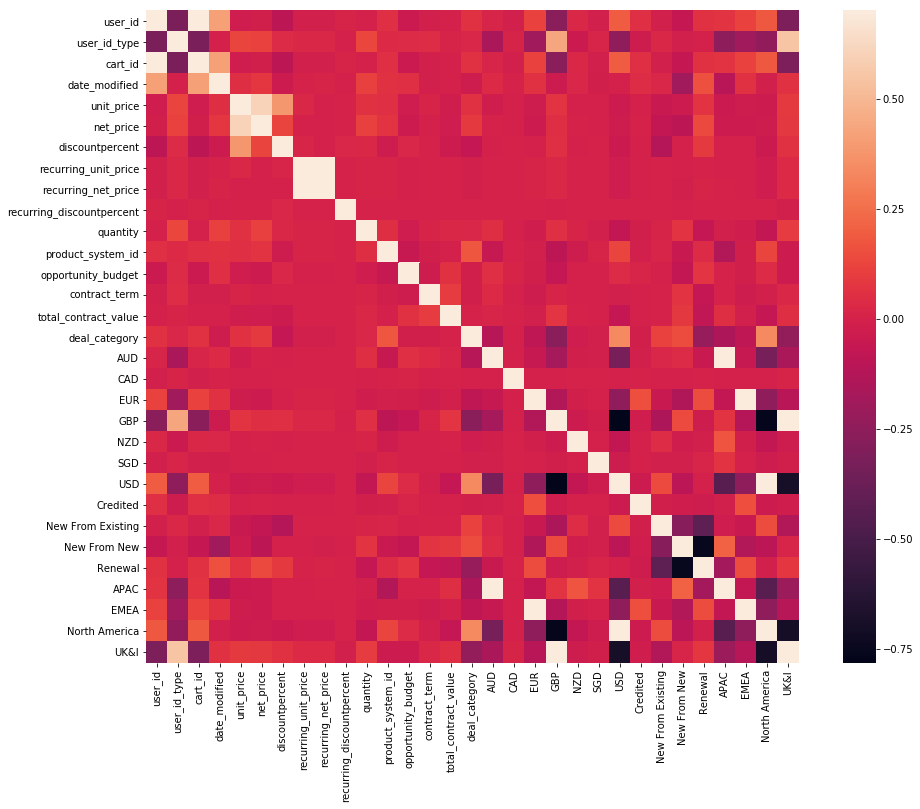

In [3]:
features = df1.corr()
f, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(features, vmax=0.7, square=True)

In [4]:
#features with high correlation score
most_pertinent = features['discountpercent'].sort_values(ascending=False)
most_pertinent = most_pertinent[abs(most_pertinent) >= 0.008]
most_pertinent = most_pertinent[most_pertinent.index != 'discountpercent']
most_pertinent

unit_price                   0.381883
net_price                    0.121078
Renewal                      0.087438
UK&I                         0.057729
GBP                          0.052946
user_id_type                 0.037379
quantity                     0.028346
opportunity_budget           0.021339
recurring_discountpercent    0.020895
recurring_unit_price         0.011201
product_system_id           -0.032999
total_contract_value        -0.035565
date_modified               -0.040714
USD                         -0.046276
North America               -0.046344
deal_category               -0.067749
cart_id                     -0.091977
user_id                     -0.091978
New From Existing           -0.122994
Name: discountpercent, dtype: float64

In [5]:
X = df1[most_pertinent.index]
y = df1['discountpercent']

I then split the data into a training set and a test set to prevent overfitting/underfitting

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Linear Regression

In [9]:
lm = linear_model.LinearRegression()

In [10]:
model = lm.fit(X_train, y_train)
lm_predictions = lm.predict(X_test)

Text(0,0.5,'Predictions')

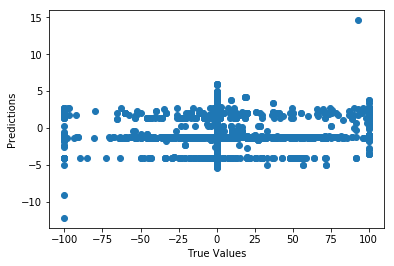

In [42]:
plt.scatter(y_test, lm_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [12]:
linear_mse = mean_squared_error(y_test, lm_predictions)
linear_mae = mean_absolute_error(y_test, lm_predictions)
print(linear_mse, linear_mae)

359.6087621798575 5.830034020098198


LinearRegression shows a very high mean squared error and mean absolute error several times above the standard deviation (.1912). As mentioned above, data shows a multi-class separation making linear regression a poor model for this dataset

## K-Nearest Neighbors Regressor

In [13]:
knn = KNeighborsRegressor()

In [14]:
knn.fit(X_train, y_train)
knn_predictions = knn.predict(X_test)

In [15]:
knn_mse = mean_squared_error(y_test, knn_predictions)
knn_mae = mean_absolute_error(y_test, knn_predictions)
print(knn_mse, knn_mae)

78.53694737034708 1.7569678693249906


A KNN model performs slightly better than linear regression but still shows a mean absolute error well above the standard deviation (1.75 vs .1912)

## Random Forest Regressor

In [16]:
rf = RandomForestRegressor(random_state=23)

In [17]:
rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_test)

/Users/Beto/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


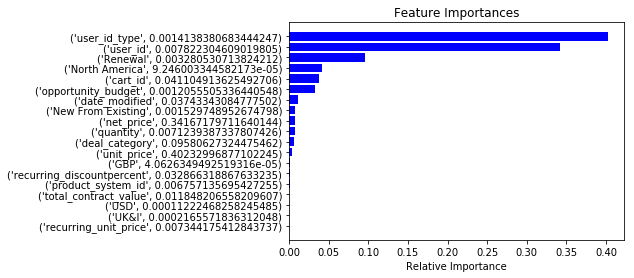

In [18]:
importances = rf.feature_importances_
sorted_feature_importance = sorted(zip(list(X_train), importances), reverse=True)
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [sorted_feature_importance[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [19]:
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_mae = mean_absolute_error(y_test, rf_predictions)
print(rf_mse, rf_mae)

6.61186809040007 0.18490366909254238


The RandomForest regressor performs slightly better than the standard deviation (.185 vs .1912), and the feature importance plot shows that user_id_type and user_id had a strong correlation to discount price

## GridSearchCV

In [20]:
param_grid = {'bootstrap': [True],
                'max_depth': [80, 90],
                'max_features': [2, 3],
                'min_samples_leaf': [3, 4, 5],
                'min_samples_split': [8, 10],
                'n_estimators': [100, 200]}

In [21]:
rfr = RandomForestRegressor()

In [22]:
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [23]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 195.0min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=23, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [80, 90], 'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5], 'min_samples_split': [8, 10], 'n_estimators': [100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [28]:
best_grid = grid_search.best_estimator_
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 200}

In [40]:
best_grid.fit(X_train, y_train)
best_grid_predictions = best_grid.predict(X_test)

In [41]:
best_grid_mse = mean_squared_error(y_test, best_grid_predictions)
best_grid_mae = mean_absolute_error(y_test, best_grid_predictions)
print(best_grid_mse, best_grid_mae)

24.72886892176963 1.1540971883016837


## Conclusion

## The best performing model was the RandomForest regressor with a mean absolute error of .185 which performed slightly better than baseline.

Moving forward, tuning the RandomForest hyperparameters with a GridSearchCV will require more computational resources. A few other methods could also be used to fine tune this model. Imputing total_contract_value NaN values and opportunity_budget values by KNN could improve this prediction. Additionally, since over/undersampling the imbalanced target variable may yeild incorrect predictions, another method would be to implement a step-wise classification (0 or non-zero) and succesive regression (continuous value prediction). 